In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_histogram

# A quantum algorithm for string mathing

### Niroula, P., Nam, Y. A quantum algorithm for string matching. npj Quantum Inf 7, 37 (2021). https://doi.org/10.1038/s41534-021-00369-3

A binary string $T$ has $N$ length and a pattern $P$ has $M$ length:<br>
$|T\rangle=\bigotimes_{i=0}^{N-1}|t_{i}\rangle$,<br>
$|P\rangle=\bigotimes_{j=0}^{M-1}|p_{j}\rangle$.<br>

The paper assumes $N=2^n$. An index register $I$ with $n$ qubits is added.<br>
Therefore, a composite initial state is
$|\psi\rangle=|0\rangle^{\bigotimes n}TP=|0\rangle^{\bigotimes n}[\bigotimes_{i=0}^{N-1}|t_{i}\rangle][\bigotimes_{j=0}^{M-1}|p_{j}\rangle]$.

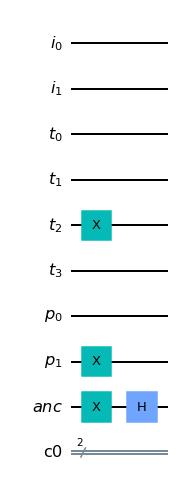

In [2]:
# T: 0100 (binary)
# P: 10 (binary)

N = 4
M = 2
n = 2

I =  QuantumRegister(n, name='i')
T = QuantumRegister(N, name='t')
P = QuantumRegister(M, name='p')

anc = QuantumRegister(1, name='anc')

c = ClassicalRegister(n)

qc =  QuantumCircuit(I, T, P, anc, c)
# Initialize T and P
qc.x(T[2])
qc.x(P[1])
# Initialize an ancilla bit
qc.x(anc)
qc.h(anc)
qc.draw('mpl')

Apply Hadamard transform $H^{\bigotimes n}$ on the index bit and make superposition<br>
$(H^{\bigotimes n}|0\rangle^{\bigotimes n})[\bigotimes_{i=0}^{N-1}|t_{i}\rangle][\bigotimes_{j=0}^{M-1}|p_{j}\rangle]$<br>
$=(\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}|k\rangle)[\bigotimes_{i=0}^{N-1}|t_{i}\rangle][\bigotimes_{j=0}^{M-1}|p_{j}\rangle]$.

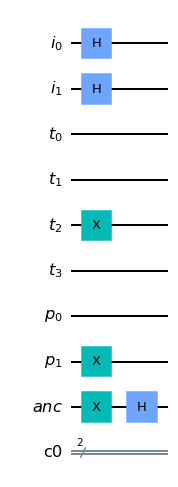

In [3]:
qc.h(I)
qc.draw('mpl')

Next step: a cyclic-shift operator $S$ (left-circular shift).

$[S(\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}|k\rangle)(\bigotimes_{i=0}^{N-1}|t_{i}\rangle)](\bigotimes_{j=0}^{M-1}|p_{j}\rangle)$<br>
$=\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}|k\rangle(\bigotimes_{i=0}^{N-1}|t_{i+k}\rangle)(\bigotimes_{j=0}^{M-1}|p_{j}\rangle)$.

The cyclic-shift operator is implemented with controlled-SWAP (Fredkin) gates&mdash;details are in the paper.

In [4]:
# Fredkin Gate
def Fredkin(qc, control, target1, target2):
    qc.cx(target2, target1)
    qc.ccx(control, target1, target2)
    qc.cx(target2, target1)

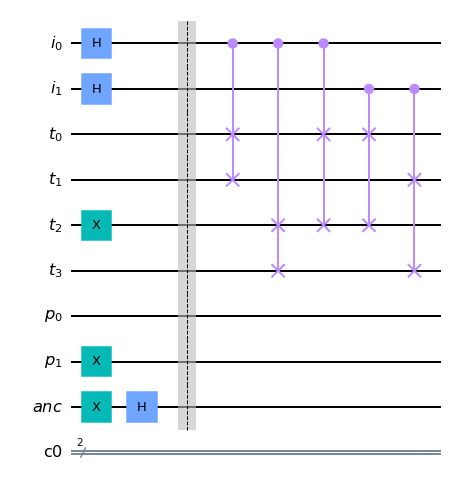

In [5]:
qc.barrier()

# 1 shift
qc.cswap(I[0], T[0], T[1]) #Fredkin(qc, I[0], T[0], T[1])
qc.cswap(I[0], T[2], T[3]) #Fredkin(qc, I[0], T[2], T[3])
qc.cswap(I[0], T[0], T[2]) #Fredkin(qc, I[0], T[0], T[2])
# 2 shift
qc.cswap(I[1], T[0], T[2]) #Fredkin(qc, I[1], T[0], T[2])
qc.cswap(I[1], T[1], T[3]) #Fredkin(qc, I[1], T[1], T[3])

qc.draw('mpl')

In this example, the relationship between index and T string can be described:

| Index $I$ | string $T$ |
|:---:|:---:|
| $00$ | $0100$ |
| $01$ | $1000$ |
| $10$ | $0001$ |
| $11$ | $0010$ |

Then, an XOR operation is used for checking string match. CNOT gates works for it.

$\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}|k\rangle CNOT^{\bigotimes M}[(\bigotimes_{i=0}^{N-1}|t_{i+k}\rangle)(\bigotimes_{j=0}^{M-1}|p_{j}\rangle)]$<br>
$=\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}[|k\rangle(\bigotimes_{i=0}^{N-1}|t_{i+k}\rangle)(\bigotimes_{j=0}^{M-1}|p_{j}\bigoplus t_{j+k}\rangle)]$


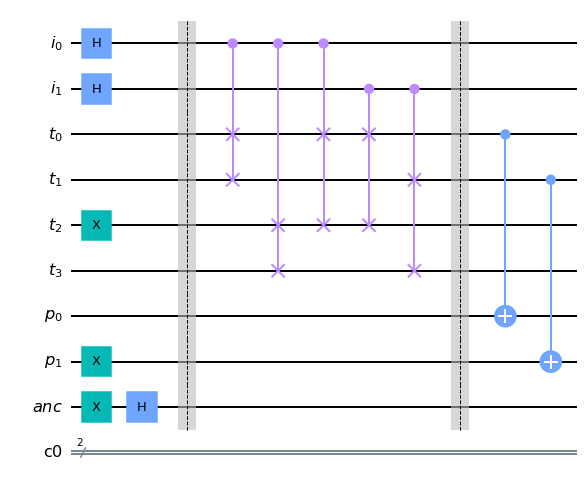

In [6]:
qc.barrier()

qc.cx(T[0], P[0])
qc.cx(T[1], P[1])

qc.draw('mpl')

Now, apply Grover's algorithm.

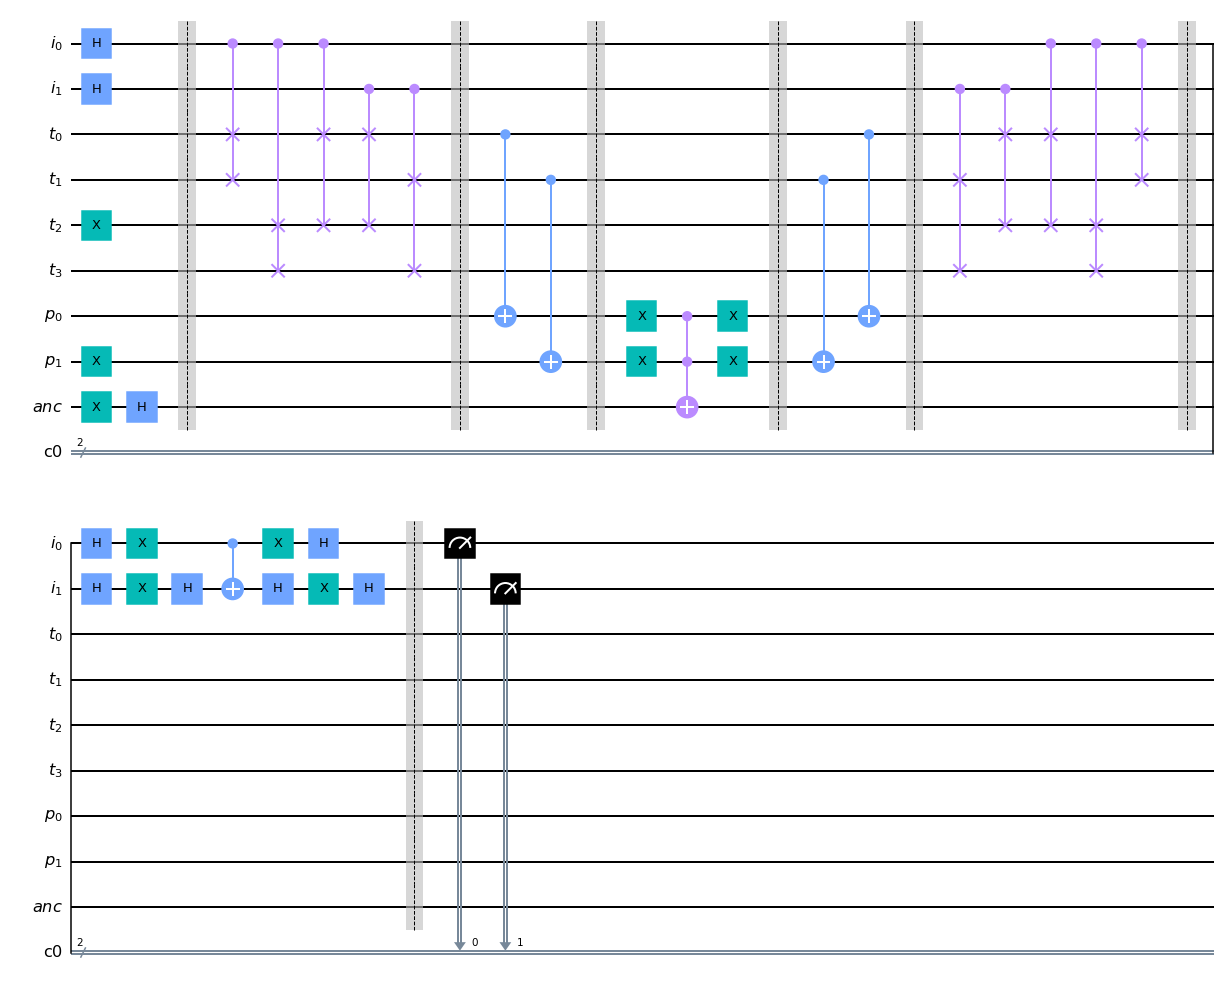

In [7]:
# Set ancilla bit
qc.barrier()
qc.x(P)
qc.ccx(P[0], P[1], anc)
qc.x(P)

# inverse the oracle
qc.barrier()
qc.cx(T[1], P[1])
qc.cx(T[0], P[0])
qc.barrier()
qc.cswap(I[1], T[1], T[3]) #Fredkin(qc, I[1], T[1], T[3])
qc.cswap(I[1], T[0], T[2]) #Fredkin(qc, I[1], T[0], T[2])
qc.cswap(I[0], T[0], T[2]) #Fredkin(qc, I[0], T[0], T[2])
qc.cswap(I[0], T[2], T[3]) #Fredkin(qc, I[0], T[2], T[3])
qc.cswap(I[0], T[0], T[1]) #Fredkin(qc, I[0], T[0], T[1])
qc.barrier()

# diffuser
qc.h(I)
qc.x(I)
qc.h(I[-1])
qc.cx(I[0], I[1]) #qc.mct(I[:-1], I[-1])
qc.h(I[-1])
qc.x(I)
qc.h(I)

qc.barrier()
qc.measure(I, c)

qc.draw('mpl')

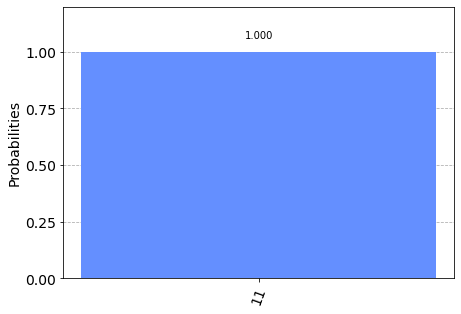

In [8]:
shots = 1024
backend = Aer.get_backend('qasm_simulator')
count = execute(qc, backend=backend, shots=shots).result().get_counts()
plot_histogram(count)

According to the table,

| Index $I$ | string $T$ |
|:---:|:---:|
| $00$ | $0100$ |
| $01$ | $1000$ |
| $10$ | $0001$ |
| $11$ | $0010$ |

we can figure out where the pattern $P$ is in the string $T$.

<sub>Personal opinion: Right-circular shift would be more intuitive.</sub>